In [3]:
import cv2
import numpy as np
from skimage import io
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

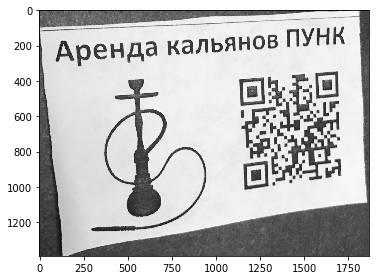

In [4]:
image_name = "image0.jpg"
image = cv2.imread(image_name)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
io.imshow(gray)

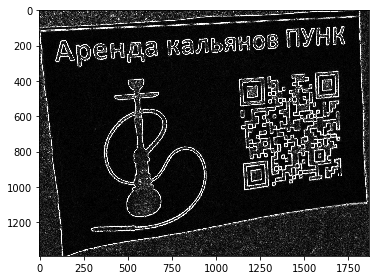

In [5]:
gradX = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = 3)
gradY = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = 3)
 
gradient = abs(gradX) + abs(gradY)
gradient = cv2.convertScaleAbs(gradient)
io.imshow(gradient)

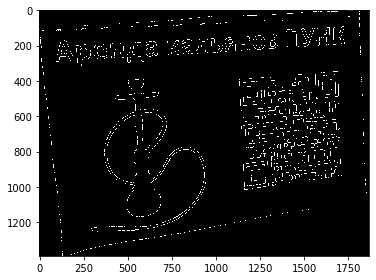

In [6]:
blurred = cv2.blur(gradient, (3, 3))
(_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
io.imshow(thresh)

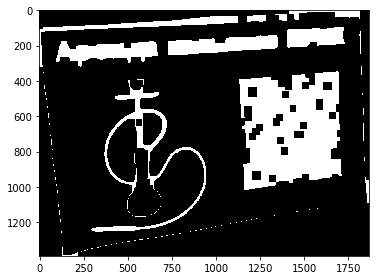

In [7]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int((min(image.shape[:-1]))*0.028), int((min(image.shape[:-1]))*0.028)))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
io.imshow(closed)

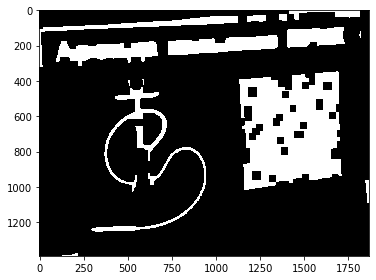

In [8]:
closed = cv2.erode(closed, None, iterations = 2)
closed = cv2.dilate(closed, None, iterations = 2)
io.imshow(closed)

In [9]:
(cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL,
cv2.CHAIN_APPROX_NONE)

cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
box_0 = np.int0(cv2.boxPoints(cv2.minAreaRect(cnt)))
center = [np.average(box_0[:,0]), np.average(box_0[:,1])]
cnt = np.array([i[0] for i in cnt.tolist()])

In [10]:
center = [np.average(cnt[:,0]),np.average(cnt[:,1])]
cnt2 = (cnt)**2 - np.array(center)**2
sum_cnt2 = cnt2[:,0] + cnt2[:,1]
indeces = [sum_cnt2.tolist().index(min(sum_cnt2)),sum_cnt2.tolist().index(max(sum_cnt2))]
a_c = cnt[indeces]
a, c1 = a_c.tolist()
center = [np.average(a_c[:,0]),np.average(a_c[:,1])]
k = (c1[1] - a[1])/(c1[0] - a[0])
b = -k*a[0] + a[1]
cnt_dl = cnt[cnt[:,1] - center[1] >= 0]
dist = abs(-k*cnt_dl[:,0] + cnt_dl[:,1] - b)/(k**2 + 1)**0.5
d = cnt_dl[dist == max(dist)].tolist()[0]
cnt_ur = cnt[cnt[:,1] - center[1] <= 0]
dist = abs(-k*cnt_ur[:,0] + cnt_ur[:,1] - b)/(k**2 + 1)**0.5
b = cnt_ur[dist == max(dist)].tolist()[0]

# c2 = [b[0] + d[0] - a[0], b[1] + d[1] - a[1]]
# cs = list(map(sum,(np.array([c1, c2]) - center)**2))
# c = [c1, c2][cs.index(max(cs))]

box = np.array([a,b,c1,d])

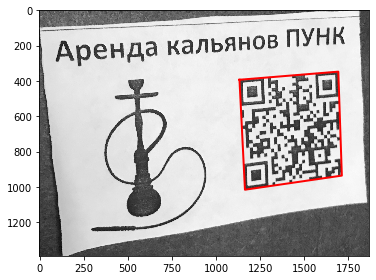

In [11]:
io.imshow(gray)
plt.plot(np.append(box[:,0],box[0,0]), np.append(box[:,1],box[0,1]), 'r', lw=2)

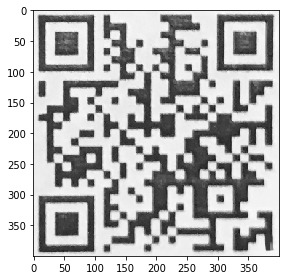

In [12]:
delta = np.linalg.norm(np.array(a) - np.array(d)) * 0.02
box[:,0] = [i - delta if i < center[0] else i + delta for i in box[:,0]]
box[:,1] = [i + delta if i > center[1] else i - delta for i in box[:,1]]
center = [np.average(box[:,0]),np.average(box[:,1])]
box_new = ((box-center)>=0)*400

pts1 = np.float32(box.tolist())
pts2 = np.float32(box_new.tolist())

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(gray,M,(400,400))

io.imshow(dst)

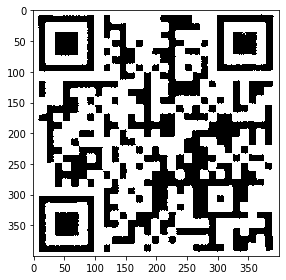

In [13]:
image = dst
thresh = threshold_otsu(image)
binary = image > thresh

io.imshow(binary)

In [14]:
for i in range(min(binary.shape)):
  if (False in binary[:i, i]) and (False in binary[i, :i]):
    if binary[:i, i].tolist().index(False) < binary[i, :i].tolist().index(False):
      a = [i, binary[:i, i].tolist().index(False)]
    else:
      a = [binary[i, :i].tolist().index(False), i]
    break

for i in range(min(binary.shape)-1, 0, -1):
  if (False in binary[i:, i]) and (False in binary[i, i:]):
    if 400 - list(reversed(binary[i:, i].tolist())).index(False) > 400 - list(reversed(binary[i, i:].tolist())).index(False):
      c1 = [i, 400 - list(reversed(binary[i:, i].tolist())).index(False)]
    else:
      c1 = [400 - list(reversed(binary[i, i:].tolist())).index(False), i]
      break

binary2 = binary[::-1]

for i in range(min(binary2.shape)):
  if (False in binary2[:i, i]) and (False in binary2[i, :i]):
    if binary2[:i, i].tolist().index(False) < binary2[i, :i].tolist().index(False):
      d = [i, 400 - binary2[:i, i].tolist().index(False)]
    else:
      d = [binary2[i, :i].tolist().index(False), 400 - i]
    break

for i in range(min(binary2.shape)-1, 0, -1):
  if (False in binary2[i:, i]) and (False in binary2[i, i:]):
    if 400 - list(reversed(binary2[i:, i].tolist())).index(False) > 400 - list(reversed(binary2[i, i:].tolist())).index(False):
      b = [i, list(reversed(binary2[i:, i].tolist())).index(False)]
    else:
      b = [400 - list(reversed(binary2[i, i:].tolist())).index(False), 400 - i]
    break

c2 = [b[0] + d[0] - a[0], b[1] + d[1] - a[1]]
cs = list(map(sum,(np.array([c1, c2]) - np.array([b[0]+d[0], b[1]+d[1]])/2 )**2))
c = [c1, c2][cs.index(max(cs))]

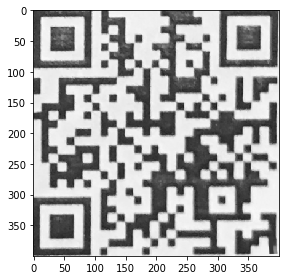

In [15]:
pts1 = np.float32([a,b,c,d])
pts2 = np.float32([[0,0],[400,0],[400,400],[0,400]])
M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(dst,M,(400,400))

io.imshow(dst)

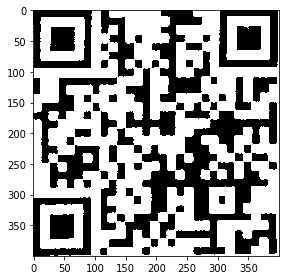

In [16]:
image = dst
thresh = threshold_otsu(image)
binary = image > thresh

io.imshow(binary)

In [17]:
cur_color = 0
diag1 = 0
count = 0
for i in range(400):
  if cur_color != binary[i, 399-i]:
    count += 1
    cur_color = binary[i, 399-i]
  if count == 5:
    diag1 = i
    break

cur_color = 0
diag2 = 0
count = 0
for i in range(399, 0, -1):
  if cur_color != binary[i, 399-i]:
    count += 1
    cur_color = binary[i, 399-i]
  if count == 5:
    diag2 = 400 - i
    break

cur_color = 0
diag3 = 0
count = 0
for i in range(400):
  if cur_color != binary[i, i]:
    count += 1
    cur_color = binary[i, i]
  if count == 5:
    diag3 = i
    break

for i in range(10, 400):
  if sum(np.append(binary[:i, i],binary[i, :i]) != 0) == i*2:
    diag4 = i-1
    break

for i in range(10, 400):
  if sum(np.append(binary[:i, 399 - i],binary[i, 400 - i:]) != 0) == i*2:
    diag5 = i-1
    break
    
for i in range(10, 400):
  if sum(np.append(binary[400-i:, i],binary[399-i, :i]) != 0) == i*2:
    diag6 = i-1
    break

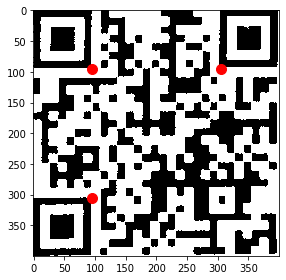

In [18]:
mean_diag_left = np.average([diag1, diag3,diag4,diag5,diag6])
mean_diag_up = np.average([diag2, diag3,diag4,diag5,diag6])
pixel4_left = mean_diag_left - mean_diag_left/7
pixel5_left = mean_diag_left
pixel4_up = mean_diag_up - mean_diag_up/7
pixel5_up = mean_diag_up

io.imshow(binary)

plt.plot([mean_diag_left], [mean_diag_up], 'o--r', markersize=10)
plt.plot([400 - mean_diag_left], [mean_diag_up], 'o--r', markersize=10)
plt.plot([mean_diag_left], [400 - mean_diag_up], 'o--r', markersize=10)

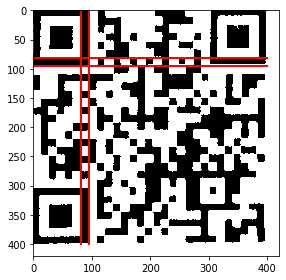

In [19]:
io.imshow(binary)
plt.plot([pixel4_left, pixel4_left], [0, 400], 'r', lw=2)
plt.plot([pixel5_left, pixel5_left], [0, 400], 'r', lw=2)
plt.plot([0, 400], [pixel4_up, pixel4_up], 'r', lw=2)
plt.plot([0, 400], [pixel5_up, pixel5_up], 'r', lw=2)

In [20]:
counts = []
for l in range(int(np.ceil(int(pixel4_up))), int(np.floor(int(pixel5_up)))):
  cur_color = 0
  count1 = 0
  for i in range(diag4+1, 400-diag5-1):
    if cur_color != binary[i, l]:
      count1 += 1
      cur_color = binary[i, l]
  counts += [count1]
    
for l in range(int(np.ceil((pixel4_left))), int(np.floor(pixel5_left))):
  cur_color = 0
  count2 = 0
  for i in range(diag4+1, 400-diag6-1):
    if cur_color != binary[l, i]:
      count2 += 1
      cur_color = binary[l, i]  
  counts += [count2] 

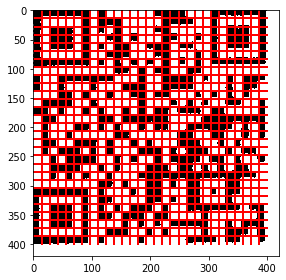

In [24]:
total_count = (max(set(counts), key=counts.count) + 7*2)
one_pixel = 400 / total_count

io.imshow(binary)

for i in range(1, total_count):
  plt.plot([i*one_pixel, i*one_pixel], [0, 400], 'r', lw=2)
  plt.plot([0, 400], [i*one_pixel, i*one_pixel], 'r', lw=2)

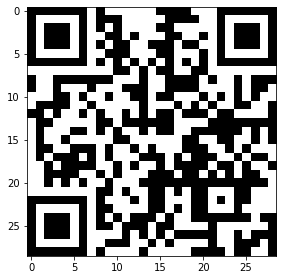

In [22]:
qr_code = np.zeros([total_count,total_count])
for i in range(total_count):
  for j in range(total_count):
    array = binary[int(np.ceil(i*one_pixel)):int(np.floor((i+1)*one_pixel)), int(np.floor(j*one_pixel)):int(np.ceil((j+1)*one_pixel))].tolist()
    qr_code[i,j] = int(np.rint(np.average([np.average(a) for a in array])))

io.imshow(qr_code)
plt.savefig('qr_code.jpg')

In [23]:
im = cv2.imread(image_name)
det = cv2.QRCodeDetector()
retval1, points1, straight_qrcode1 = det.detectAndDecode(im)
print('Количество неверно определенных пикселей:', int(sum(sum((straight_qrcode1/255) - qr_code))))

Количество неверно определенных пикселей: 0
